# Analysis of Drug Shortage database

The data we are using for our analysis contains historical data from 2017 to present. All these records has been reported by the Food and Drug Regulations require drug to sellers are not able to meet demand for a product or when they stop selling a product.

Shortage reports have 3 different stages and can be resolved as shown below

# ![image](Shortage_stages.jpg)

In [80]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import xlrd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
warnings.filterwarnings('ignore')

In [81]:
df = pd.read_csv("Shortage data/combined_data.csv")
df.tail()

,file_name,report_id,drug_identification_number,brand_name,company_name,common_or_proper_name,ingredients,strength_s,packaging_size,actual_start_date,actual_end_date
19416,2023_Canada_Shortage.xlsx,183684,2373130.0,XYLOCAINE 2% WITH EPINEPHRINE 1:200000,ASPEN PHARMACARE CANADA INC.,lidocaine HCI 2% w/epin. 1:200M 10x20mL MD Vial,EPINEPHRINE\r LIDOCAINE HYDROCHLORIDE,0.005MG\r 20MG,10 vials,NaN,NaN
19417,2023_Canada_Shortage.xlsx,185721,2153432.0,ZINECARD,PFIZER CANADA ULC,ZINECARD,DEXRAZOXANE,250MG,25mL vial,2023-02-28T00:00:00Z,NaN
19418,2023_Canada_Shortage.xlsx,181739,2401606.0,ZOLEDRONIC ACID - Z,SANDOZ CANADA INCORPORATED,ZOLEDRONIC ACID,ZOLEDRONIC ACID,4MG,5ML,2023-01-18T00:00:00Z,2023-01-31T00:00:00Z
19419,2023_Canada_Shortage.xlsx,181295,2132702.0,ZOLOFT,UPJOHN CANADA ULC,ZOLOFT,SERTRALINE,25MG,100,2023-02-06T00:00:00Z,NaN
19420,2023_Canada_Shortage.xlsx,184552,2132702.0,ZOLOFT,UPJOHN CANADA ULC,ZOLFT,SERTRALINE,25MG,100,2023-02-07T00:00:00Z,NaN


In [82]:
df.dtypes

file_name                      object
report_id                       int64
drug_identification_number    float64
brand_name                     object
company_name                   object
common_or_proper_name          object
ingredients                    object
strength_s                     object
packaging_size                 object
actual_start_date              object
actual_end_date                object
dtype: object

Converting start and end date fields from object to datetime64

In [83]:
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')

In [84]:
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

Fill NaN drug_identification_number into 0, converting as int

In [85]:
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

In [86]:
df.dtypes

file_name                             object
report_id                              int64
drug_identification_number             int32
brand_name                            object
company_name                          object
common_or_proper_name                 object
ingredients                           object
strength_s                            object
packaging_size                        object
actual_start_date             datetime64[ns]
actual_end_date               datetime64[ns]
dtype: object

Removing NaN actual_start_date and actual_end_date, considering as an incomplete record

In [87]:
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

Removing duplicated Id_reports

In [88]:
df=df.drop_duplicates("report_id", keep=False)

In [89]:
# Fill Nat end date with today date
# today = datetime.today().strftime('%Y-%m-%d')
# df = df.fillna(today)

Calculating # of Days of shortage = actual - start date

In [90]:
df['Days']= df['actual_end_date']-df['actual_start_date']

In [91]:
# 
df['file_name'] = df['file_name'].str[0:4]

In [92]:
df.to_csv("data.csv", index=False)

In [93]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11427 entries, 1 to 19418
Columns: 12 entries, file_name to Days
dtypes: datetime64[ns](2), int32(1), int64(1), object(7), timedelta64[ns](1)
memory usage: 1.1+ MB


In [94]:
din = df['drug_identification_number'].mode()
din


0    717002
dtype: int32

Clean outliers, clean data previous to 2017

In [95]:
df2 = df.drop(['file_name',	'report_id',	'drug_identification_number',	'brand_name',	'company_name',	'common_or_proper_name',	'ingredients',	'strength_s',	'packaging_size','actual_end_date'],axis=1)
df2 = df2.loc[(df['actual_start_date'] >= '2017-01-01')]


In [96]:
df2

,actual_start_date,Days
1,2017-11-15,6 days
2,2018-03-01,28 days
4,2018-01-19,42 days
6,2017-11-17,122 days
8,2017-09-13,428 days
...,...,...
19389,2023-01-09,9 days
19405,2023-01-26,19 days
19406,2023-01-11,34 days
19410,2023-01-31,7 days


In [97]:
df2.columns = ['ds', 'y']
df2['y'] = df2['y'].dt.days
df2.head()

,ds,y
1,2017-11-15,6
2,2018-03-01,28
4,2018-01-19,42
6,2017-11-17,122
8,2017-09-13,428


### Training the time series model

In [98]:
p = Prophet(interval_width=0.5, daily_seasonality=True)

Now train the model.

In [99]:
model = p.fit(df2)

12:00:12 - cmdstanpy - INFO - Chain [1] start processing
12:00:25 - cmdstanpy - INFO - Chain [1] done processing


### Making predictions and evaluating performance

In [100]:
future = p.make_future_dataframe(periods=50, freq='D')
future.tail()

,ds
1576,2024-02-05
1577,2024-02-06
1578,2024-02-07
1579,2024-02-08
1580,2024-02-09


In [101]:
forecast_prediction = p.predict(future)
forecast_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,394.164176,322.724979,561.987217,394.164176,394.164176,59.666057,59.666057,59.666057,-85.430957,...,163.826287,163.826287,163.826287,-18.729273,-18.729273,-18.729273,0.0,0.0,0.0,453.830233
1,2017-01-03,393.208393,116.948411,354.657900,393.208393,393.208393,-157.691689,-157.691689,-157.691689,-85.430957,...,-52.442103,-52.442103,-52.442103,-19.818629,-19.818629,-19.818629,0.0,0.0,0.0,235.516705
2,2017-01-04,392.730502,131.135705,379.283781,392.730502,392.730502,-142.426641,-142.426641,-142.426641,-85.430957,...,-36.929921,-36.929921,-36.929921,-20.065763,-20.065763,-20.065763,0.0,0.0,0.0,250.303861
3,2017-01-06,391.774720,128.607577,362.651206,391.774720,391.774720,-150.371327,-150.371327,-150.371327,-85.430957,...,-44.914736,-44.914736,-44.914736,-20.025634,-20.025634,-20.025634,0.0,0.0,0.0,241.403393
4,2017-01-10,389.863154,101.580975,342.828727,389.863154,389.863154,-156.275886,-156.275886,-156.275886,-85.430957,...,-52.442103,-52.442103,-52.442103,-18.402826,-18.402826,-18.402826,0.0,0.0,0.0,233.587269


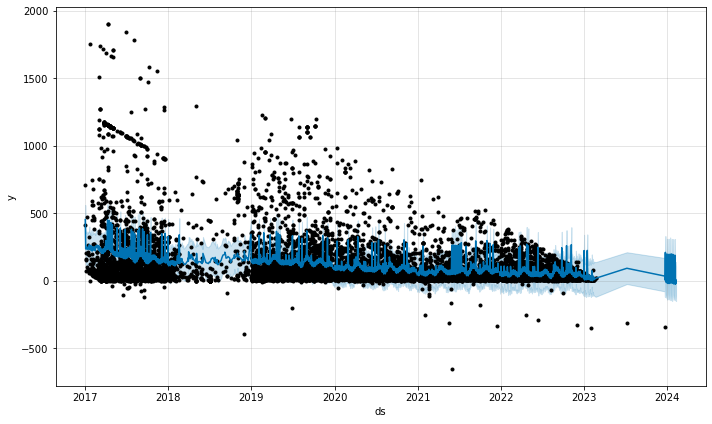

In [102]:
plot1 = p.plot(forecast_prediction)

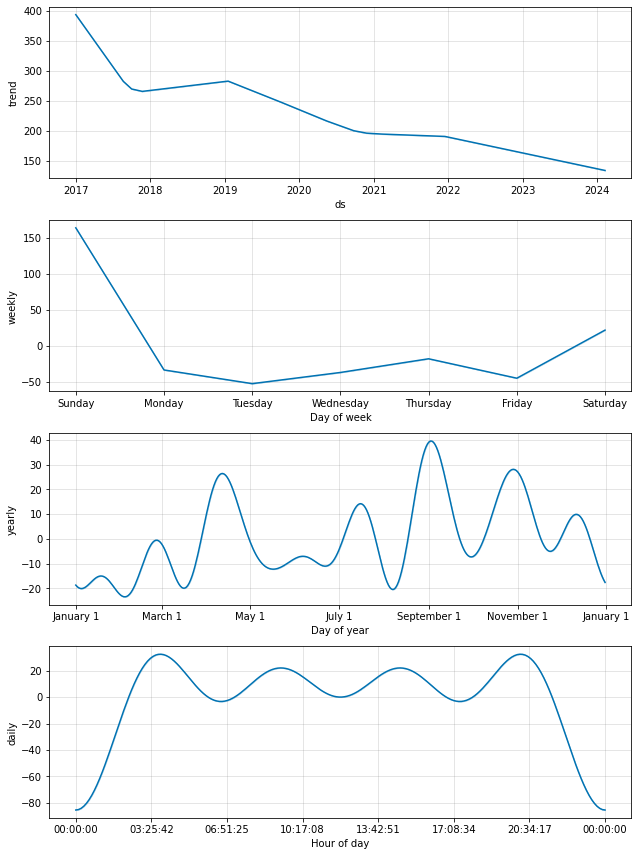

In [103]:
plot2 = p.plot_components(forecast_prediction)